# Predicting Positions
The point of this analysis is to use player data dating back to 1950 to create a classifier model that predicts the position of a player using the scikit-learn library.  Further analysis will be done to see if the model can predict players that are listed at multiple positions, and if they are able to capture changes in a player's position over time.

In [311]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Prepare Data for Analysis
Import the datasets 'Players.csv' and 'Seasons_Stats.csv'.  Players contains information about each of the players in the NBA since 1950, while stats is a multidimensional dataset containing individual player statistics, both regular and advanced, for the same set of players. 

In [111]:
players = pd.read_csv('Players.csv', index_col=0)
stats = pd.read_csv('Seasons_Stats.csv', index_col=0)
print(players.head())
print(stats.head())

            Player  height  weight                          collage    born  \
0  Curly Armstrong   180.0    77.0               Indiana University  1918.0   
1     Cliff Barker   188.0    83.0           University of Kentucky  1921.0   
2    Leo Barnhorst   193.0    86.0         University of Notre Dame  1924.0   
3       Ed Bartels   196.0    88.0  North Carolina State University  1925.0   
4      Ralph Beard   178.0    79.0           University of Kentucky  1927.0   

    birth_city birth_state  
0          NaN         NaN  
1     Yorktown     Indiana  
2          NaN         NaN  
3          NaN         NaN  
4  Hardinsburg    Kentucky  
     Year           Player  Pos   Age   Tm     G  GS  MP  PER    TS%  ...    \
0  1950.0  Curly Armstrong  G-F  31.0  FTW  63.0 NaN NaN  NaN  0.368  ...     
1  1950.0     Cliff Barker   SG  29.0  INO  49.0 NaN NaN  NaN  0.435  ...     
2  1950.0    Leo Barnhorst   SF  25.0  CHS  67.0 NaN NaN  NaN  0.394  ...     
3  1950.0       Ed Bartels    F  24

We will drop the blank columns.  Looking at the players dataset, both height and weight of players should have some value in predicting the position a player plays.  We will merge the data set on the player name to add height and weight to the data set we are operating on.  In addition, because we will be considering 3-point shooting as a factor in our analysis, we will exclude player stats from before 1980, when the 3-point line was added to the game.  Finally, we will exclude players who played less than 400 minutes in the season and players who were classified at more than one position (<2 % of the dataset).

In [280]:
stats.drop(['blanl','blank2'],axis=1)
stats_players = pd.merge(players[['Player','height','weight']],stats,on='Player').fillna(0)
qual_players = stats_players[stats_players.MP > 400]
modern_stats = qual_players[qual_players.Year > 1979]
modern_stats.height = modern_stats.height.apply(lambda x: x* 0.3937)
modern_stats = modern_stats[modern_stats.Pos.isin(['PG','SG','SF','PF','C'])]

C:\Python34\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [281]:
print(modern_stats.head())

          Player   height  weight    Year Pos   Age   Tm     G    GS      MP  \
1642  Jim Paxson  77.9526    90.0  1980.0  SG  22.0  POR  72.0   0.0  1270.0   
1643  Jim Paxson  77.9526    90.0  1981.0  SG  23.0  POR  79.0   0.0  2701.0   
1644  Jim Paxson  77.9526    90.0  1982.0  SG  24.0  POR  82.0  82.0  2756.0   
1645  Jim Paxson  77.9526    90.0  1983.0  SG  25.0  POR  81.0  81.0  2740.0   
1646  Jim Paxson  77.9526    90.0  1984.0  SG  26.0  POR  81.0  81.0  2686.0   

       ...      FT%   ORB    DRB    TRB    AST    STL   BLK    TOV     PF  \
1642   ...    0.711  25.0   84.0  109.0  144.0   48.0   5.0   93.0   97.0   
1643   ...    0.734  74.0  137.0  211.0  299.0  140.0   9.0  131.0  172.0   
1644   ...    0.767  75.0  146.0  221.0  276.0  129.0  12.0  144.0  159.0   
1645   ...    0.812  68.0  106.0  174.0  231.0  140.0  17.0  156.0  160.0   
1646   ...    0.841  68.0  105.0  173.0  251.0  122.0  10.0  142.0  165.0   

         PTS  
1642   443.0  
1643  1354.0  
1644  1552.

# Create classification model

We will use scikit-learn's RandomForestClassifier to create a classification model that predicts each player's position.  

In [283]:
predictors = ['3PAr','FTr','TRB%','AST%','BLK%','TOV%','height','weight','Year']
X = modern_stats[predictors]
y = modern_stats.Pos
train_X, test_X, train_y, test_y = train_test_split(X, y)

# Replace NaN values with mean
my_imputer = Imputer()
train_X_imputed = my_imputer.fit_transform(train_X)
test_X_imputed = my_imputer.transform(test_X)

# Specify model
my_model = RandomForestClassifier(n_estimators=300)
my_model.fit(train_X_imputed, train_y)

# Use model to predict positions for test set
y_predicted = my_model.predict(test_X_imputed)

# Print feature importances and accuracy scores
print('Feature Importances are:')
for i in range(len(predictors)):
    print(predictors[i] + ': ' + str(my_model.feature_importances_[i]))
print('Accuracy score is ' + str(my_model.score(test_X_imputed,test_y)))

Feature Importances are:
3PAr: 0.0895017367147
FTr: 0.0599946336417
TRB%: 0.186064427284
AST%: 0.17067111492
BLK%: 0.0758104674238
TOV%: 0.067519449557
height: 0.190762272997
weight: 0.101689028171
Year: 0.0579868692907
Accuracy score is 0.809022556391


Normalized confusion matrix


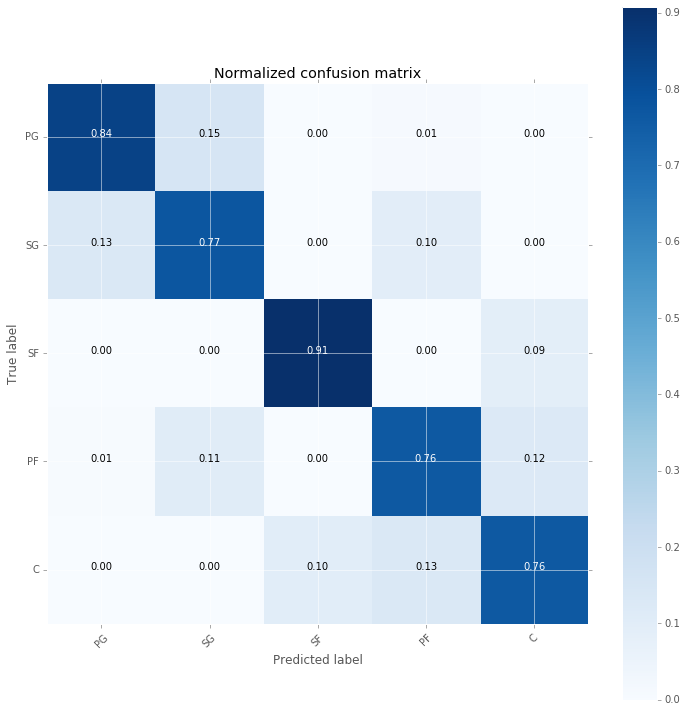

In [289]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, y_predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize = (10,10))
plot_confusion_matrix(cnf_matrix, classes=['PG','SG','SF','PF','C'], normalize=True,title='Normalized confusion matrix')

plt.show()

Looking at the confusion matrix of the results, we see that our model did a good job predicting the positions across all five positions.  The position that was predicted most accurately was the small forward position, with 91% of the players classified correctly.

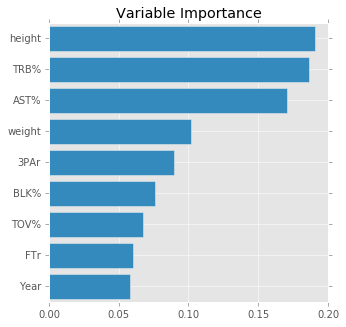

In [433]:
#Plot Feature Importances
npPred = np.array(predictors)
importances = my_model.feature_importances_
sorted_idx = np.argsort(importances)
padding = np.arange(len(predictors)) + 0.5
plt.figure(figsize=(5,5))
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, npPred[sorted_idx])
plt.title("Variable Importance")
plt.show()

We have plotted the feature importances in a bar chart to observe if there are any variables that we should clearly drop.  The bar chart shows that TRB%, height, and AST% are the most important features in predicting a player's position.  There is a sharp drop off in relative importance after those three features, but the other 5 features are close in relative importance, so we will keep them in our model.

# Effect of Year on Position - "Time Machine"
Next we will analyze whether changing the year will have an effect on the position.  It is a common belief that the NBA is getting smaller, trending towards lineups with guards and forwards and away from the former convention of having a big 7-footer at center.  We will use the All-NBA First and Second Teams from 2017 and the same RandomForestClassifier model to predict their position over the years.  The idea is to observe whether the position has changed over time, and a player might be classified at a different position at an earlier point in time.

First, we will take a look to see how well the model did predicting these players' positions.

In [227]:
all_nba_members = ['Russell Westbrook', 'James Harden', 'Anthony Davis', 'LeBron James', 'Kawhi Leonard', 'Kevin Durant',
                  'Stephen Curry', 'Isaiah Thomas', 'Rudy Gobert', 'Giannis Antetokounmpo']
all_nba_stats = modern_stats[[((x[1]['Player'] in all_nba_members) & (x[1]['Year']==2017)) for x in modern_stats.iterrows()]]
all_nba_stats = all_nba_stats.loc[:,['Player','Year','Pos','3PAr','FTr','TRB%','AST%','BLK%','TOV%','height','weight']]
all_nba_stats

,Player,Year,Pos,3PAr,FTr,TRB%,AST%,BLK%,TOV%,height,weight
19684,LeBron James,2017.0,SF,0.254,0.395,12.6,41.3,1.3,16.1,79.9211,113.0
21674,Kevin Durant,2017.0,SF,0.304,0.374,13.6,23.1,3.8,10.4,81.1022,108.0
22416,Russell Westbrook,2017.0,PG,0.300,0.433,17.1,57.3,0.9,15.9,74.8030,90.0
22527,Stephen Curry,2017.0,PG,0.547,0.251,7.3,31.1,0.5,13.0,74.8030,86.0
22638,James Harden,2017.0,PG,0.493,0.575,12.2,50.7,1.0,19.5,77.1652,99.0
23400,Kawhi Leonard,2017.0,SF,0.294,0.407,9.8,18.9,1.8,9.1,79.1337,104.0
23518,Isaiah Thomas,2017.0,PG,0.439,0.441,4.4,32.6,0.4,10.7,72.8345,81.0
23662,Anthony Davis,2017.0,C,0.088,0.424,17.3,11.1,5.1,9.1,81.1022,97.0
23943,Giannis Antetokounmpo,2017.0,SF,0.143,0.486,14.3,26.6,4.7,13.3,83.0707,100.0
24045,Rudy Gobert,2017.0,C,0.002,0.763,21.8,5.7,6.4,15.1,85.0392,111.0


In [228]:
pd.DataFrame(index=all_nba_stats.loc[:, 'Player'].values, data={'Real': all_nba_stats.loc[:, 'Pos'].values,
    'Predicted':my_model.predict(all_nba_stats.loc[:,predictors])})

,Predicted,Real
LeBron James,PF,SF
Kevin Durant,PF,SF
Russell Westbrook,PG,PG
Stephen Curry,PG,PG
James Harden,PG,PG
Kawhi Leonard,SF,SF
Isaiah Thomas,PG,PG
Anthony Davis,C,C
Giannis Antetokounmpo,SG,SF
Rudy Gobert,C,C


Now let's take a look at how the model predicts each of these players' positions for each year dating back to 1980.  In other words, if each player put up their 2017 stats in other years, what position would they be classified under?

In [261]:
#Set range of years to be used
years = np.arange(1980,2018)
aging_predicted = []

for p in all_nba_stats.iterrows():
    aging = pd.concat([p[1].to_frame().T for x in years], axis=0)
    aging['Year'] = years

    X = aging
    y = aging['Pos'].as_matrix()

    aging_predicted.append(pd.DataFrame(index=years, data={'Real': aging.loc[:, 'Pos'].values,
                                                           'Predicted':my_model.predict(X[predictors])}))

In [290]:
time_machine = pd.concat(aging_predicted,axis=1,keys=all_nba_stats['Player'])
time_machine

Player LeBron James      Kevin Durant      Russell Westbrook       \
          Predicted Real    Predicted Real         Predicted Real   
1980             PF   SF           PF   SF                PG   PG   
1981             PF   SF           PF   SF                PG   PG   
1982             PF   SF           PF   SF                PG   PG   
1983             PF   SF           PF   SF                PG   PG   
1984             PF   SF           PF   SF                PG   PG   
1985             PF   SF           PF   SF                PG   PG   
1986             PF   SF           PF   SF                PG   PG   
1987             PF   SF           PF   SF                PG   PG   
1988             PF   SF           PF   SF                PG   PG   
1989             PF   SF           PF   SF                PG   PG   
1990             PF   SF           PF   SF                PG   PG   
1991             PF   SF           PF   SF                PG   PG   
1992             PF   SF           PF   SF                PG   PG   
1993             PF   SF           PF   SF                PG   PG   
1994             PF   SF           PF   SF                PG   PG   
1995             PF   SF           PF   SF                PG   PG   
1996             PF   SF           PF   SF                PG   PG   
1997             PF   SF           PF   SF                PG   PG   
1998             PF   SF           PF   SF                PG   PG   
1999             PF   SF           PF   SF                PG   PG   
2000             PF   SF           PF   SF                PG   PG   
2001             PF   SF           PF   SF                PG   PG   
2002             PF   SF           PF   SF                PG   PG   
2003             PF   SF           PF   SF                PG   PG   
2004             PF   SF           PF   SF                PG   PG   
2005             PF   SF           PF   SF                PG   PG   
2006             PF   SF           PF   SF                PG   PG   
2007             PF   SF           PF   SF                PG   PG   
2008             PF   SF           PF   SF                PG   PG   
2009             PF   SF           PF   SF                PG   PG   
2010             PF   SF           PF   SF                PG   PG   
2011             PF   SF           PF   SF                PG   PG   
2012             PF   SF           PF   SF                PG   PG   
2013             PF   SF           PF   SF                PG   PG   
2014             PF   SF           PF   SF                PG   PG   
2015             PF   SF           PF   SF                PG   PG   
2016             PF   SF           PF   SF                PG   PG   
2017             PF   SF           PF   SF                PG   PG   

Player Stephen Curry      James Harden      Kawhi Leonard      Isaiah Thomas  \
           Predicted Real    Predicted Real     Predicted Real     Predicted   
1980              PG   PG           PG   PG            SF   SF            PG   
1981              PG   PG           PG   PG            SF   SF            PG   
1982              PG   PG           PG   PG            SF   SF            PG   
1983              PG   PG           PG   PG            SF   SF            PG   
1984              PG   PG           PG   PG            SF   SF            PG   
1985              PG   PG           PG   PG            SF   SF            PG   
1986              PG   PG           PG   PG            SF   SF            PG   
1987              PG   PG           PG   PG            SF   SF            PG   
1988              PG   PG           PG   PG            SF   SF            PG   
1989              PG   PG           PG   PG            SF   SF            PG   
1990              PG   PG           PG   PG            SF   SF            PG   
1991              PG   PG           PG   PG            SF   SF            PG   
1992              PG   PG           PG   PG            SF   SF            PG   
1993              PG   PG           PG 

Looking at the predicted positions in time_machine, the only two players on the all_nba_team that would be classified as a different position over time would be Anthony Davis and Giannis Antetokounmpo.

In [263]:
time_machine.loc[:,['Anthony Davis', 'Giannis Antetokounmpo']]

Player Anthony Davis      Giannis Antetokounmpo     
           Predicted Real             Predicted Real
1980              PF    C                    SG   SF
1981              PF    C                    SG   SF
1982              PF    C                    SG   SF
1983              PF    C                    SG   SF
1984              PF    C                    SG   SF
1985              PF    C                    SG   SF
1986              PF    C                    SF   SF
1987              PF    C                    SF   SF
1988              PF    C                    SF   SF
1989              PF    C                    SF   SF
1990              PF    C                    SF   SF
1991              PF    C                    SF   SF
1992              PF    C                    SF   SF
1993              PF    C                    SF   SF
1994              PF    C                    PF   SF
1995              PF    C                    SF   SF
1996              PF    C                    SF   SF
1997              PF    C                    SF   SF
1998              PF    C                    SF   SF
1999              PF    C                    SF   SF
2000               C    C                    SF   SF
2001               C    C                    PF   SF
2002               C    C                    PF   SF
2003               C    C                    PF   SF
2004              PF    C                    PF   SF
2005              PF    C                    PF   SF
2006              PF    C                    SG   SF
2007              PF    C                    SG   SF
2008              PF    C                    SG   SF
2009              PF    C                    SG   SF
2010              PF    C                    SG   SF
2011              PF    C                    SG   SF
2012              PF    C                    SG   SF
2013               C    C                    SG   SF
2014               C    C                    SG   SF
2015               C    C                    SG   SF
2016               C    C                    SG   SF
2017               C    C                    SG   SF

Going back in time, Anthony Davis' 2017 stats would have made him a Power Forward from 1980-1999 and 2004-2012.  The 4 years in between, from 2000-2003, and for the last 5 years, Davis would be considered a center.  This supports the claim that recenty the NBA has trended towards smaller lineups, due to Davis' classification as a PF during the 80s and 90s.

Looking at time machine Giannis, his position oscillates between SG, SF, and PF over the 28 season span.  Shooting guard is the position that appears most often, but he is classified as a small forward almost as often.  This supports the claim that Giannis is indeed a freak and we have never seen a player like him before.

# Examining the Greek Freak
Focusing on Giannis, we see that his position has varied throughout his short career.  Let's see how well the model has captured his position changes year-to-year.

In [422]:
#Display Giannis' stats for his career so far
print('Real Positions')
print(modern_stats.loc[:,['Player','Year','Pos','3PAr','FTr','TRB%','AST%','BLK%','TOV%','height','weight']][modern_stats.Player == 'Giannis Antetokounmpo'])

#Use the model to predict Giannis' positions
print('Predicted Positions')
print(my_model.predict(modern_stats[predictors][modern_stats.Player == 'Giannis Antetokounmpo']), end = '\n')

#Display the probabilities of classifying Giannis as each positions by year
print('Position Order for Probability')
print(my_model.classes_)
print('Probability of Each Position')
print(my_model.predict_proba(modern_stats[predictors][modern_stats.Player == 'Giannis Antetokounmpo']))

Real Positions
                      Player    Year Pos   3PAr    FTr  TRB%  AST%  BLK%  \
23940  Giannis Antetokounmpo  2014.0  SF  0.282  0.483  10.2  12.1   2.6   
23941  Giannis Antetokounmpo  2015.0  SG  0.056  0.445  12.2  13.1   2.8   
23942  Giannis Antetokounmpo  2016.0  PG  0.108  0.404  12.4  20.0   3.4   
23943  Giannis Antetokounmpo  2017.0  SF  0.143  0.486  14.3  26.6   4.7   

       TOV%   height  weight  
23940  19.4  83.0707   100.0  
23941  15.6  83.0707   100.0  
23942  14.8  83.0707   100.0  
23943  13.3  83.0707   100.0  
Predicted Positions
['SF' 'SG' 'PF' 'SF']
Position Order for Probability
['C' 'PF' 'PG' 'SF' 'SG']
Probability of Each Position
[[ 0.05  0.14  0.    0.78  0.03]
 [ 0.14  0.16  0.    0.07  0.63]
 [ 0.19  0.4   0.    0.25  0.15]
 [ 0.15  0.12  0.    0.68  0.04]]


Looking at the results, the model correctly predicted Giannis' position in 2014, 2015, and 2017.  It fails to predict the correct position in 2016, when he played Point Guard (Point Giannis).  Based on the probability matrix, the chances of being classified as a PG is 0 in all years. This suggests that either his height or his weight is preventing a classification as a PG due to those being the only two factors that have not changed throughout his career.

# Shrinking Giannis 
Ideally, the model wouldn't be shallow enough to restrict a player's position solely based on their size.  However, the failure to classify Giannis as a PG suggests this may be the case.  To check, we will decrease his height and weight to see if we can get the model to classify him as a point guard.  We will use a similar approach as the time machine, but instead change the height and weight.  

In [423]:
all_nba_stats16 = modern_stats[[((x[1]['Player'] in all_nba_members) & (x[1]['Year']==2016)) for x in modern_stats.iterrows()]]
all_nba_stats16 = all_nba_stats16.loc[:,['Player','Year','Pos','3PAr','FTr','TRB%','AST%','BLK%','TOV%','height','weight']]

#Set range of heights to be used
multiplier = np.arange(0.87,0.98,.01)
shrinking_predicted = []

for p in all_nba_stats16.iterrows():
    shrinking = pd.concat([p[1].to_frame().T for x in multiplier], axis=0)
    shrinking['height'] = shrinking['height'] * multiplier
    shrinking['weight'] = shrinking['weight'] * multiplier

    X = shrinking
    y = shrinking['Pos'].as_matrix()

    shrinking_predicted.append(pd.DataFrame(index=heights, data={'Height (in)': shrinking.loc[:, 'height'].values,
                                                                 'Weight (kg)': shrinking.loc[:, 'weight'].values,
                                                           'Predicted Position':my_model.predict(X[predictors])}))

In [424]:
shrink = pd.concat(shrinking_predicted,axis=1,keys=all_nba_stats['Player'])
shrink.loc[:,'Giannis Antetokounmpo']

,Height (in),Predicted Position,Weight (kg)
72,72.2715,PG,87
73,73.1022,PG,88
74,73.9329,PF,89
75,74.7636,PF,90
76,75.5943,PF,91
77,76.425,PF,92
78,77.2558,SF,93
79,78.0865,SF,94
80,78.9172,SF,95
81,79.7479,SF,96


Looking at the table, we were able to shrink Giannis enough to get him classified as a PG.  The size we had to shrink Giannis to in order to achieve this was ~73 inches (6'1") and 90 kg (194 lbs).  This likely corresponds to a ~9 year old Giannis.  While we achieved our goal, this demonstrates the limits of the model, which is restricted by the height and weight of the player.